# Total Dissolved Gas Prediction and Optimization

## Introduction 

The United States Army Corps of Engineers (USACE) operates dams on the Columbia River and lower Snake River, which provides the region with irrigation, hydropower production, flood control, navigation, and fish passage. The USACE has had to adapt to changing priorities and demands with regard to spill and TDG levels throughout the two river systems as one of its primary operators.  

The USACE spilled to the maximum allowable TDG levels allowed by Oregon and Washington water quality standards during the 2018 spill season due to a court order.  This is a change from past operation, which had designated a target spill at most dams.  Shifting prioirities and demands from competing stakeholders are predicted to continue in coming years.  Newer more accurate models to predict TDG levels and stay within state water quality standards are necessary for the USACE to operate under the law and provide a framework that is transparent to stakeholders.   

Oak Ridge National Laboratory, with funding from the United States Bureau of Reclemation (USBR), developed an empirical optimization model to predict tail water TDG levels.  The model used physical parameters such as spill and hydropower flow proportions, accompanied by the characteristics of the dam such as plant head levels and tailrace depths.  The work provided an easy to use emperical equation with 3 optimized coefficients for each modeled dam.  Dam operators and water quality experts can apply these equations in a spreadsheet environment.  THis makes the process quick and accessible to all engineering and technical staff associated with the projects.  The work only produced coefficients for dams operated by USBR, not the USACE.

Fortunately the work has been well documented in the "Total dissolved gas prediction and optimization in RIVERWARE," and the optimization process can be easily repeated and applied to the USACE dams.



## Model Organization

This model consists of 3 parts
1. Configuration file
2. Script file
3. Set of Jupyter Notebooks 

### Configuration File

The configuration file is in yaml format that consists of the required project pathnames for the physical parameter data located in the CWMS database.  An example project from the configuration file is seen below:


the_dalles:<br>
  &emsp;h_t: TDA.Elev-Tailwater.Ave.1Hour.1Hour.GDACS-COMPUTED-REV<br>
  &emsp;p_atm: TDA.Pres-Air.Inst.1Hour.0.GOES-REV<br>
  &emsp;q_p: TDA.Flow-Gen.Ave.1Hour.1Hour.CBT-REV<br>
  &emsp;q_s: TDA.Flow-Spill.Ave.1Hour.1Hour.CBT-REV<br>
  &emsp;temp_water: TDA.Temp-Water.Inst.1Hour.0.GOES-REV<br>
  &emsp;tdg_f: TDA.%-Saturation-TDG.Inst.1Hour.0.GOES-COMPUTED-REV<br>
  &emsp;tdg_tw: TDDO.%-Saturation-TDG.Inst.1Hour.0.GOES-COMPUTED-REV<br>


### Script File

The script util.py contains the 3 required equations (functions) found in the study "Total dissolved gas prediction and optimization in RIVERWARE," outlined below, as well as some utility functions for conversion.  Please refer to util.py or "Total dissolved gas prediction and optimization in RIVERWARE," for further explanation of the below equations.

\begin{align}
A& = \bigg[\frac{Q_S+b_1Q_s+b3}{Q_s+Q_p}\bigg] &\quad\quad\text{eq 1}\\
\\
B& =  \bigg[1+ \frac{P_{TW}}{2P_{atm}} \bigg]&\quad\quad\text{eq 2} \\
\\
C& = \bigg[\frac{Q_p-b_1Q_s-b_3}{Q_s+Q_p}\bigg] &\quad\quad\text{eq 3} \\
\\
\end{align}

Where:

A = &emsp;Weighted contribution of spillway plus powerhouse entrainment flows for adjusting dependency
 of TDG’s production on tailwater depth.<br><br>
B = &emsp;TDG’s dependency on tailwater depth as referenced to atmospheric pressure and adjusted by a fitted
 dissolution efficiency coefficient (b2).<br><br>
C = &emsp;Weighted contributions of the difference between the powerhouse and its entrainment flows used to
 adjust the fraction of forebay TDG <br>
 &emsp;&emsp;&emsp;transferred downstream.<br><br>


The three equations are combined in the optimization objective function to determine tailwater TDG in the equation below.  Root mean squared error is used to determine loss.

$$TDG_T = 100\bigg[\frac{Q_s+b_1Q_s+b3}{Q_s+Q_p}\bigg]\bigg[1+ \frac{P_{TW}}{2P_{atm}} \bigg]b_2+TDG_F\bigg[\frac{Q_p-b_1Q_s-b_3}{Q_s+Q_p}\bigg]$$


### Jupyter Notebooks

The model uses several Jupyter Notebooks and Netflix's Jupyter Extension, Nteract as well as its Papermill Python library.  The Nteract extension allows notebooks to be parameterized therefore making the notebooks reusable and extensible.  The Papermill library is able to extract data from a notebook and pass it to a subsequent notebook creating a model flow.  A Jupyter Notebook is associated with each model step.  A diagram of the model's linear process is seen below. 

<img src="../images/driver.png">




#### Collect 
Data is collected from the CWMS database and saved in a Jupyter Notebook.
#### Split 
The data is split into k-folds for cross validation with k equal to the number of years of available data.  Each fold is saved into a Jupyter Notebook split into a train and test set.
#### Optimize
The optimization process is performed on each fold for cross-validation and then on the entire dataset to obtain the final coefficients.
#### Validate
The residual error of each of the folds is aggregated and displayed below in a histogram as well as a tabular format and actual vs predicted values are compared in a qq plot.  The coefficients are displayed for each of the folds as well. The same process is done on the complete dataset with the entire dataset set to both the training and test set. 


In [1]:
import yaml
import os
import papermill as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
#params
data_directory = os.path.abspath(os.path.join(r'D:\gitClones\nteract_models\optimize\projects'))
config = yaml.load(open('../config.yml'))
project_name = ''

In [3]:

def get_errors(nb_df):
    errors= nb_df[nb_df['name'] == 'error'].reset_index(drop = True)
    df_list = []
    for row in errors.iterrows():
        d = pd.DataFrame(row[1]['value']) 
        d['filename'] = row[1]['filename']
        df_list.append(d)
    error_df = pd.concat(df_list, ignore_index=True)
    return error_df


def make_hist(error_df):
    hist, edges = np.histogram(error_df['error'].dropna(), density=True)
    n_bins = len(hist)
    # turn off interactive plotting to avoid double plotting
    plt.hist(error_df['error'], bins=n_bins)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')



def make_qq(error_df):
    # turn off interactive plotting to avoid double plotting
    y_min = error_df['y'].min()
    y_max = error_df['y'].max()

    plt.plot([y_min,y_max], [y_min,y_max], color = 'red') 
    plt.scatter(error_df['y'],error_df['y_hat'], alpha = .1)
    
    plt.xlabel('y (%)')
    plt.ylabel('y hat (%)')

def make_plots(error_df):
    p = plt.figure(figsize=(10,5))
    plt.ioff()
    y_min = error_df['y'].min()
    y_max = error_df['y'].max()
    
    plt.subplot(121)
    make_hist(error_df)
    
    plt.subplot(122)
    make_qq(error_df)
    
    return p

def get_coefficients(nb_df):
    b = nb_df[(nb_df['name']=='b1') | (nb_df['name'] == 'b2') | (nb_df['name'] == 'b3')].copy()
    b = b.pivot(columns = 'name', values = 'value', index = 'filename')
    b.reset_index(inplace = True)
    b.reset_index(drop=True, inplace = True)
    
    return b






In [5]:
config.pop('the_dalles')

{'h_t': 'TDA.Elev-Tailwater.Ave.1Hour.1Hour.GDACS-COMPUTED-REV',
 'p_atm': 'TDA.Pres-Air.Inst.1Hour.0.GOES-REV',
 'q_p': 'TDA.Flow-Gen.Ave.1Hour.1Hour.CBT-REV',
 'q_s': 'TDA.Flow-Spill.Ave.1Hour.1Hour.CBT-REV',
 'tdg_f': 'TDA.%-Saturation-TDG.Inst.1Hour.0.GOES-COMPUTED-REV',
 'tdg_tw': 'TDDO.%-Saturation-TDG.Inst.1Hour.0.GOES-COMPUTED-REV',
 'temp_water': 'TDA.Temp-Water.Inst.1Hour.0.GOES-REV'}

In [7]:
config.pop('bonneville')

{'h_t': 'BON.Elev-Tailwater.Inst.1Hour.0.CBT-RAW',
 'p_atm': 'BON.Pres-Air.Inst.1Hour.0.GOES-REV',
 'q_p': 'BON.Flow-Gen.Ave.1Hour.1Hour.CBT-REV',
 'q_s': 'BON.Flow-Spill.Ave.1Hour.1Hour.CBT-REV',
 'tdg_f': 'BON.%-Saturation-TDG.Inst.1Hour.0.GOES-COMPUTED-REV',
 'tdg_tw': 'CCIW.%-Saturation-TDG.Inst.1Hour.0.GOES-COMPUTED-REV',
 'temp_water': 'BON.Temp-Water.Inst.1Hour.0.GOES-REV'}

## Results

### John Day

#### John Day Cross Validated Results

C:\Continuum\anaconda2\envs\ds\lib\site-packages\numpy\lib\function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


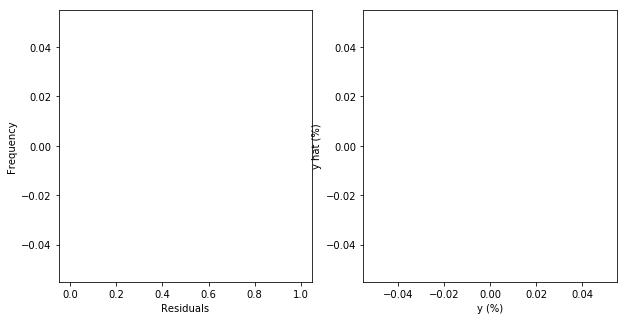

##### Cross-Validated Error

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: error, dtype: float64

##### k-fold Coefficients

name,filename


#### John Day Results Using All Data

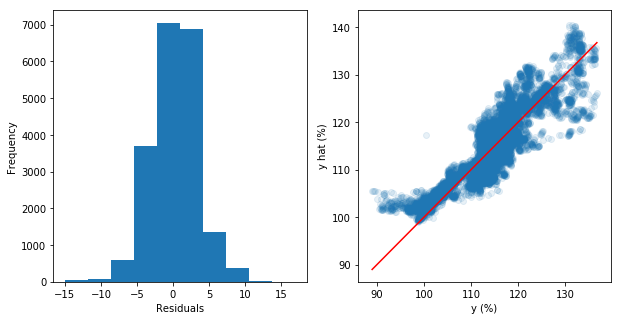

##### Model Error

count    20110.000000
mean         0.192802
std          3.223959
min        -15.013220
25%         -1.916332
50%          0.578769
75%          2.000986
max         16.998633
Name: error, dtype: float64

##### Model Coefficients

name,filename,b1,b2,b3
0,john_day_optimized_all_error.ipynb,-1.00354,-12.8221,-0.00106027


In [8]:
from IPython.display import display, Markdown
for k,v in config.items():
    project_name = k
    title = '### {}'.format(project_name.replace('_',' ').title())
    display(Markdown(title))
    #project_directory = os.path.join(data_directory, project_name.replace(' ', '_').lower())
    #error_directory = os.path.join(project_directory,'error')
    error_directory = r'D:\gitClones\nteract_models\optimize\projects\temp\error'
    nbs = pm.read_notebooks(error_directory)
    nb_df = nbs.dataframe
    error_df = get_errors(nb_df)
    
    
    cv_title = '#### {} Cross Validated Results'.format(project_name.replace('_',' ').title())
    display(Markdown(cv_title))
    
    cv_results_error = error_df[~error_df['filename'].str.contains("_all")]
    cv_results_coef = nb_df[~nb_df['filename'].str.contains("_all")]
    
    display(make_plots(cv_results_error))
    
    display(Markdown('##### Cross-Validated Error'))###################################################Need to clean this up show some quality like rmse
    display(cv_results_error['error'].describe())
    
    display(Markdown('##### k-fold Coefficients'))
    display(get_coefficients(cv_results_coef))
    
    all_data_title = '#### {} Results Using All Data'.format(project_name.replace('_',' ').title())
    display(Markdown(all_data_title))
    
    all_results_error = error_df[error_df['filename'].str.contains("_all")]
    all_results_coef = nb_df[nb_df['filename'].str.contains("_all")]
    
    display(make_plots(all_results_error))
    display(Markdown('##### Model Error'))
    display(all_results_error['error'].describe())
    display(Markdown('##### Model Coefficients'))
    display(get_coefficients(all_results_coef))
    plt.close('all')

    
    
    
    
    